# Contenu:

[+] Problématique adressée

    Ne sachant (vraiment pas!) comment aider une commune dans sa prise de décision, essai de découverte d'insigths pour caractériser les différents types de communes quand à leurs nombre de vp électriques et leurs équipements de recharge

[+] Méthodologie

    + variables segmentation: (par commune)
        - VE_pct : pourcentage de véhicules electriques parmis tous les véhicules
        - VE_per_inhab : VE par habitants
        - VE_per_surf : nbre de VE par  hectares
        - surf_per_inhab : surface dispo par habitant

    + Embedding via UMAP
    + DBSCAN
    + Radar plots:
        * variables:
            - valeur moyennes             



In [1]:
# from tqdm.notebook import tqdm
from tqdm import tqdm

import os
os.environ['USE_PYGEOS'] = '0'

# Data management
import pandas as pd
import geopandas as gpd
import numpy as np


# Visualisation
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium.features import Choropleth
from folium.plugins import MarkerCluster

# Preprocessing
from sklearn.preprocessing import StandardScaler
import umap


# I/O
import gc
import io, requests
import zipfile, shutil
import joblib

# tqdm().pandas()

# data_path = 'C:/Users/demo/Desktop/Lattitude/datas/'
data_path = 'datas'
os.makedirs(data_path, exist_ok=True)

c:\Users\demo\miniconda3\envs\e-motion\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Datas

In [2]:
# Load the data for French garge points
file_name = 'dataset_charge_points.feather'

bornes = gpd.read_feather(os.path.join(data_path, file_name))

# Load the data for the communes
file_name = 'dataset_communes.feather'

communes = gpd.read_feather(os.path.join(data_path, file_name))

-------------------------

# Create some metric on electrics stuff

In [3]:
communes['VE_pct'] = communes.nb_vp_rechargeables_el / communes.nb_vp
communes['VE_per_inhab'] = communes.nb_vp_rechargeables_el / communes.PMUN
communes['VE_per_surf'] = communes.nb_vp_rechargeables_el / communes.surf_ha
communes['surf_per_inhab'] = communes.surf_ha / communes.PMUN 

---------------------------------------------------------------------------------------

# Select a region

In [4]:
display(set(communes.region_name), set(communes.columns) )

{'Auvergne-Rhône-Alpes',
 'Bourgogne-Franche-Comté',
 'Bretagne',
 'Centre-Val de Loire',
 'Corse',
 'Grand Est',
 'Hauts-de-France',
 None,
 'Normandie',
 'Nouvelle-Aquitaine',
 'Occitanie',
 'Pays de la Loire',
 "Provence-Alpes-Côte d'Azur",
 'Île-de-France'}

{'PCAP',
 'PMUN',
 'PTOT',
 'VE_pct',
 'VE_per_inhab',
 'VE_per_surf',
 'date_arrete',
 'dep',
 'dep_name',
 'epci',
 'geometry',
 'insee',
 'libepci',
 'libgeo',
 'nb_vp',
 'nb_vp_rechargeables_el',
 'nb_vp_rechargeables_gaz',
 'nom',
 'region_name',
 'surf_ha',
 'surf_per_inhab',
 'wikipedia'}

In [5]:
REGION = 'Normandie'

-------------------------------------

# Select a date

In [6]:
display(communes.date_arrete.isna().value_counts())

display(communes[communes.date_arrete.isna()])

display(communes.date_arrete.value_counts().sort_values(ascending=True))

False    314535
True          5
Name: date_arrete, dtype: int64

,insee,nom,wikipedia,surf_ha,geometry,PMUN,PCAP,PTOT,nb_vp,libepci,...,date_arrete,epci,nb_vp_rechargeables_el,dep,dep_name,region_name,VE_pct,VE_per_inhab,VE_per_surf,surf_per_inhab
6618,55050,Bezonvaux,fr:Bezonvaux,926.0,"POLYGON ((5.44205 49.23587, 5.44227 49.23601, ...",0.0,0.0,0.0,NaN,None,...,None,None,NaN,55,Meuse,Grand Est,NaN,NaN,NaN,inf
6791,55307,Louvemont-Côte-du-Poivre,fr:Louvemont-Côte-du-Poivre,831.0,"POLYGON ((5.37213 49.24765, 5.37243 49.24805, ...",0.0,0.0,0.0,NaN,None,...,None,None,NaN,55,Meuse,Grand Est,NaN,NaN,NaN,inf
7847,55139,Cumières-le-Mort-Homme,fr:Cumières-le-Mort-Homme,611.0,"POLYGON ((5.22597 49.23322, 5.22636 49.23332, ...",0.0,0.0,0.0,NaN,None,...,None,None,NaN,55,Meuse,Grand Est,NaN,NaN,NaN,inf
22163,14666,Sannerville,fr:Sannerville,520.0,"POLYGON ((-0.25616 49.17372, -0.25616 49.17387...",NaN,NaN,NaN,NaN,None,...,None,None,NaN,14,Calvados,Normandie,NaN,NaN,NaN,NaN
26725,27058,Les Trois Lacs,fr:Les Trois Lacs,3657.0,"POLYGON ((1.26626 49.20404, 1.27118 49.20519, ...",NaN,NaN,NaN,NaN,None,...,None,None,NaN,27,Eure,Normandie,NaN,NaN,NaN,NaN


2021-03-31    34948
2021-09-30    34948
2021-06-30    34948
2021-12-31    34948
2022-06-30    34948
2020-12-31    34948
2022-03-31    34948
2022-09-30    34949
2022-12-31    34950
Name: date_arrete, dtype: int64

In [7]:
DATE = '2021-03-31'

request = " region_name == @REGION  and date_arrete == @DATE "

--------------------------------------------

# Charge point number in the communes at DATE

In [8]:
# bornes.columns

In [9]:
pdc_at_date = bornes.query(' date_mise_en_service <= @DATE ').groupby('insee').nbre_pdc.sum()
pdc_at_date

insee
01014     10.0
01027     40.0
01053     58.0
01071      2.0
01089     32.0
         ...  
97418    109.0
97420      4.0
97422      1.0
97424      1.0
nan      352.0
Name: nbre_pdc, Length: 5335, dtype: float64

---------------------------------------------------------

# Umap datas

,nbre_pdc,nb_vp,VE_per_inhab,VE_per_surf,surf_per_inhab
22605,0.000000,6.596202,0.157696,0.087968,1.792643
21855,0.000000,6.205822,0.000000,0.000000,1.789389
19367,1.587401,7.605905,0.201443,0.213331,0.944273
26702,0.000000,7.791488,0.189622,0.199823,0.948954
15594,0.000000,5.241483,0.208078,0.120049,1.733278
33607,0.000000,6.910423,0.148559,0.157696,0.942063
22291,0.000000,7.518473,0.139673,0.089327,1.563618
21875,1.587401,13.819101,0.190449,0.329317,0.578316
19727,0.000000,5.848035,0.000000,0.000000,1.865088
22346,0.000000,7.274786,0.148075,0.108868,1.360140


,count,mean,std,min,25%,50%,75%,max
nbre_pdc,2650.0,0.217063,0.621561,0.000000,0.000000,0.000000,0.000000,7.191966
nb_vp,2650.0,8.798319,3.941619,3.072317,6.390677,7.905129,9.955637,58.564931
VE_per_inhab,2650.0,0.143420,0.084003,0.000000,0.121195,0.166917,0.198945,0.657801
VE_per_surf,2650.0,0.137976,0.103332,0.000000,0.089385,0.137580,0.188046,0.894740
surf_per_inhab,2650.0,1.247688,0.377673,0.268666,1.007329,1.234390,1.477084,2.791385


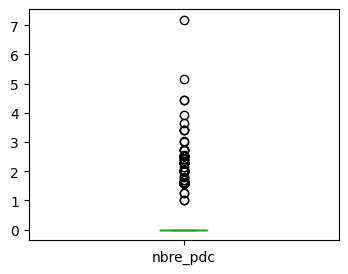

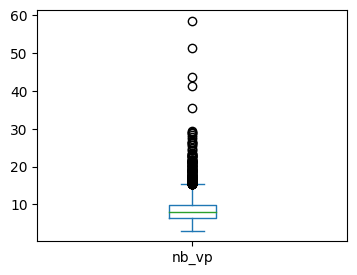

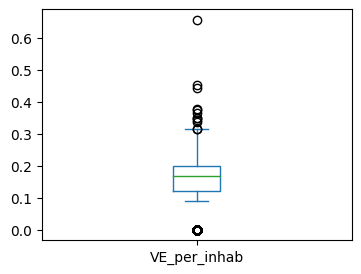

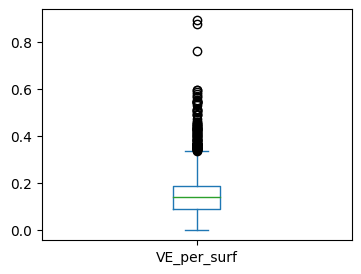

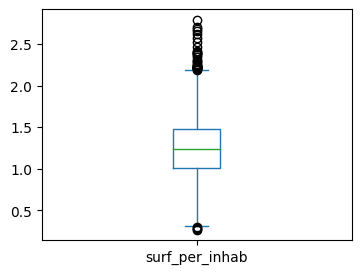

In [10]:
# Select only the columns of interest for reduction & clstering on region departments

umap_datas = communes.join(pdc_at_date, how='left', on='insee', validate='m:1')\
                     .query( request)[
                            [
                                'nbre_pdc',
                                # 'VE_pct',
                                # 'VE_per_ha',
                                'nb_vp',
                                'VE_per_inhab',
                                'VE_per_surf',
                                'surf_per_inhab', 
                            ]
                                                                
                        ]\
                     .fillna(0).apply(lambda x : x **  (1/3)) # to push left skewed distribution to normality

display(umap_datas.sample(10))

display( umap_datas.describe().T)


for col in umap_datas.columns:
    umap_datas.plot(kind='box'   , column=col, figsize=(4,3))
plt.show()    

,PCAP,PMUN,PTOT,VE_pct,VE_per_inhab,VE_per_surf,nb_vp,nb_vp_rechargeables_el,surf_ha,surf_per_inhab,nbre_pdc
28189,4.0,134.0,138.0,0.000000,0.000000,0.000000,155.0,0.0,783.0,5.843284,0.0
22462,5.0,292.0,297.0,0.006667,0.006849,0.003460,300.0,2.0,578.0,1.979452,0.0
22571,2.0,204.0,206.0,0.009217,0.009804,0.002878,217.0,2.0,695.0,3.406863,0.0
21948,59.0,4199.0,4258.0,0.007435,0.008097,0.041820,4573.0,34.0,813.0,0.193618,4.0
24753,8.0,567.0,575.0,0.003396,0.003527,0.005391,589.0,2.0,371.0,0.654321,0.0
16275,16.0,1426.0,1442.0,0.006351,0.006311,0.009091,1417.0,9.0,990.0,0.694250,0.0
21422,0.0,89.0,89.0,0.000000,0.000000,0.000000,128.0,0.0,983.0,11.044944,0.0
29139,1.0,205.0,206.0,0.000000,0.000000,0.000000,186.0,0.0,745.0,3.634146,0.0
27485,12.0,573.0,585.0,0.003044,0.003490,0.002509,657.0,2.0,797.0,1.390925,0.0
21807,13.0,673.0,686.0,0.009281,0.011887,0.005952,862.0,8.0,1344.0,1.997028,0.0


,count,mean,std,min,25%,50%,75%,max
PCAP,2650.0,27.470566,104.033730,0.000000,4.000000,8.000000,19.000000,2366.000000
PMUN,2650.0,1256.110943,5267.720368,18.000000,227.250000,449.000000,911.750000,170147.000000
PTOT,2650.0,1283.581509,5358.824171,21.000000,231.000000,458.000000,929.000000,172067.000000
VE_pct,2650.0,0.005051,0.005117,0.000000,0.001691,0.004329,0.007273,0.108588
VE_per_inhab,2650.0,0.005625,0.007849,0.000000,0.001780,0.004650,0.007874,0.284632
VE_per_surf,2650.0,0.008178,0.027415,0.000000,0.000714,0.002604,0.006650,0.716292
nb_vp,2650.0,1289.223774,5611.648279,29.000000,261.000000,494.000000,986.750000,200869.000000
nb_vp_rechargeables_el,2650.0,8.096981,42.167206,0.000000,1.000000,2.000000,6.000000,1530.000000
surf_ha,2650.0,1134.747925,1418.526623,23.000000,525.000000,799.500000,1230.000000,18993.000000
surf_per_inhab,2650.0,2.490017,2.263720,0.019393,1.022149,1.880863,3.222672,21.750000


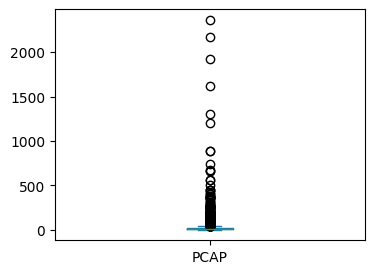

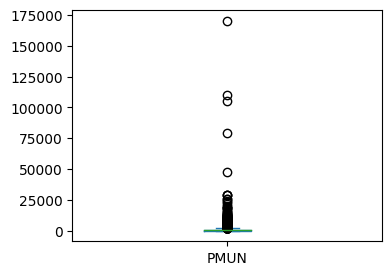

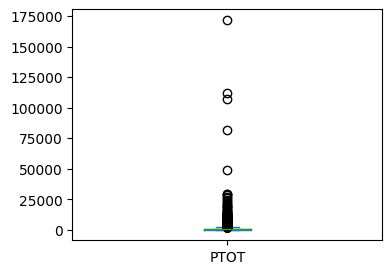

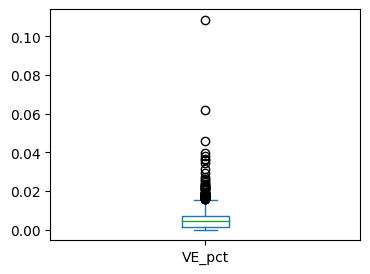

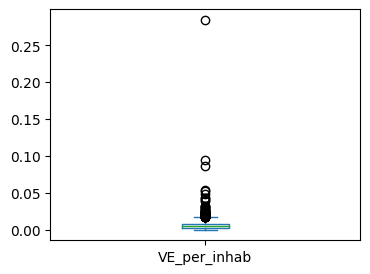

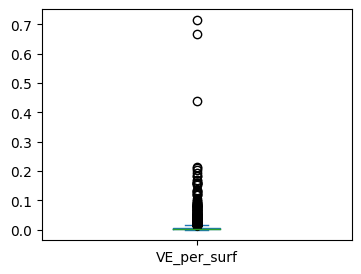

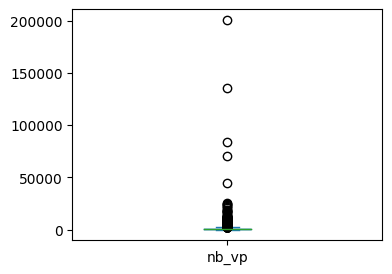

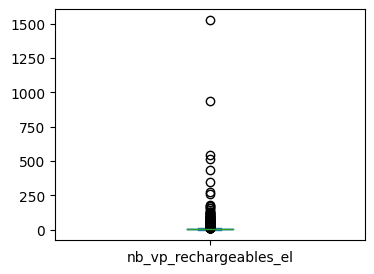

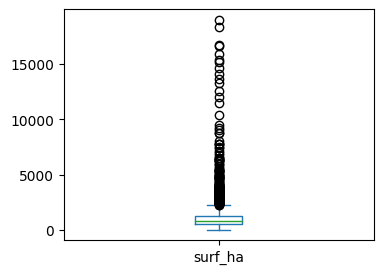

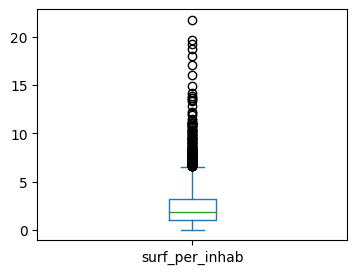

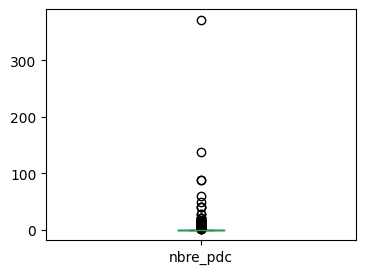

In [11]:
personas_vars = [
        'PCAP',
        'PMUN',
        'PTOT',
        'VE_pct',
        'VE_per_inhab',
        'VE_per_surf',
        # 'date_arrete',
        # 'dep',
        # 'dep_name',
        # 'epci',
        # 'geometry',
        # 'insee',
        # 'libepci',
        # 'libgeo',
        'nb_vp',
        'nb_vp_rechargeables_el',
        # 'nb_vp_rechargeables_gaz',
        # 'nom',
        # 'region_name',
        'surf_ha',
        'surf_per_inhab',
        # 'wikipedia'

        'nbre_pdc'
        ]
# Select only the columns of interest for reduction & clstering on region departments

datas_personas = communes.join(pdc_at_date, how='left', on='insee', validate='m:1')\
                         .query( request)[
                                        personas_vars
                                
                                ]\
                         .fillna(0)       

display(datas_personas.sample(10))

display(datas_personas.describe().T)


for col in datas_personas.columns:
    datas_personas.plot(kind='box'   , column=col, figsize=(4,3))

# Scale datas

In [12]:
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer, PowerTransformer

# umap_scaler = StandardScaler()
# umap_scaler = RobustScaler()
umap_scaler = QuantileTransformer()
# umap_scaler = PowerTransformer()

scaled_umap_datas = umap_scaler.fit_transform(umap_datas.values)


# personas_scaler = StandardScaler()
# personas_scaler = RobustScaler()
personas_scaler = QuantileTransformer()
# personas_scaler = PowerTransformer()

scaled_datas_personas = pd.DataFrame(personas_scaler.fit_transform(datas_personas.values),
                                    columns=datas_personas.columns,)

# UMAP

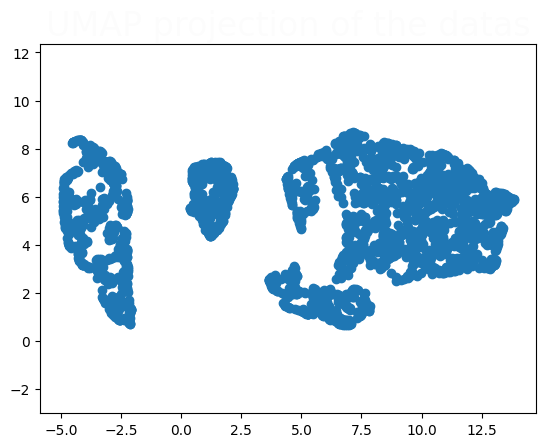

In [13]:
reducer = umap.UMAP(
            n_neighbors=25, 
            n_components=2, 
            metric='euclidean', 
            metric_kwds=None, 
            output_metric='euclidean', 
            output_metric_kwds=None, 
            n_epochs=None, 
            learning_rate=0.1, # 0.1
            init='spectral', 
            min_dist=0.1,  # 0.1
            spread=1.0,  #1.0
            low_memory=True, 
            n_jobs=-1, 
            set_op_mix_ratio=1.0, 
            local_connectivity=1.0, # 1.0
            repulsion_strength=1.0, # 1.0
            negative_sample_rate=5, 
            transform_queue_size=4.0, 
            a=None, 
            b=None, 
            random_state=None, 
            angular_rp_forest=False, 
            target_n_neighbors=-1, 
            target_metric='categorical', 
            target_metric_kwds=None, 
            target_weight=0.5, 
            transform_seed=42, 
            transform_mode='embedding', 
            force_approximation_algorithm=False, 
            verbose=False, 
            tqdm_kwds=None, 
            unique=False, 
            densmap=False, 
            dens_lambda=2.0, 
            dens_frac=0.3, 
            dens_var_shift=0.1, 
            output_dens=False, 
            disconnection_distance=None, 
            precomputed_knn=(None, None, None)
)


# Create Embeddings
embeddings = reducer.fit_transform(scaled_umap_datas)
embeddings.shape


# Plot the embeddings
plt.scatter(
    embeddings[:, 0],
    embeddings[:, 1],
    # c=[sns.color_palette()[x] for x in penguins.species.map({"Adelie":0, "Chinstrap":1, "Gentoo":2})]
    )
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP projection of the datas', fontsize=24, alpha=0.01); plt.show()


# Clustering

Estimated number of clusters: 11
Estimated number of noise points: 19


,effectives
cluster,
-1,19
0,1107
1,296
2,97
3,145
4,519
5,316
6,32
7,33


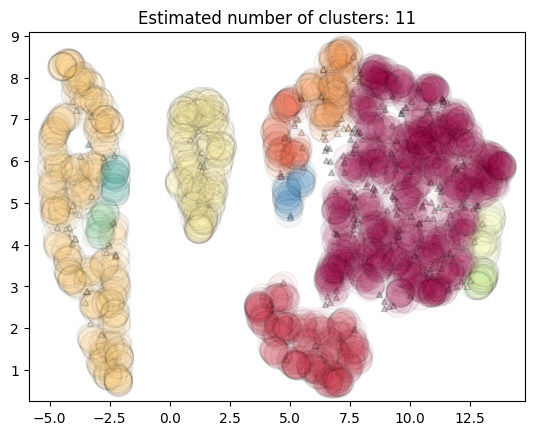

In [14]:
from sklearn.cluster import DBSCAN

dbscan = DBSCAN(
    eps=0.35,
    min_samples=10 ,
    metric='euclidean', 
    metric_params=None, 
    algorithm='auto', 
    leaf_size=30, 
    p=3, 
    n_jobs=-1)
    
dbscan .fit(embeddings)

labels = dbscan.labels_
label_, count_ = np.unique(labels, return_counts=True)
cluster_ = pd.DataFrame({'cluster': label_, 'effectives': count_}).set_index('cluster')

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print("Estimated number of clusters: %d" % n_clusters_)
print("Estimated number of noise points: %d" % n_noise_)
display(cluster_)

# #############################################################################


# Visualize the result
# # from: https://scikit-learn.org/stable/auto_examples/cluster/plot_dbscan.html#sphx-glr-auto-examples-cluster-plot-dbscan-py

unique_labels = set(labels)
core_samples_mask = np.zeros_like(labels, dtype=bool)
core_samples_mask[dbscan.core_sample_indices_] = True

colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = labels == k

    xy = embeddings[class_member_mask & core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "o",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=20,
        alpha=.05
    )

    xy = embeddings[class_member_mask & ~core_samples_mask]
    plt.plot(
        xy[:, 0],
        xy[:, 1],
        "^",
        markerfacecolor=tuple(col),
        markeredgecolor="k",
        markersize=5,
        alpha=.2
    )

plt.title(f"Estimated number of clusters: {n_clusters_}")
plt.show()

# Radar plots

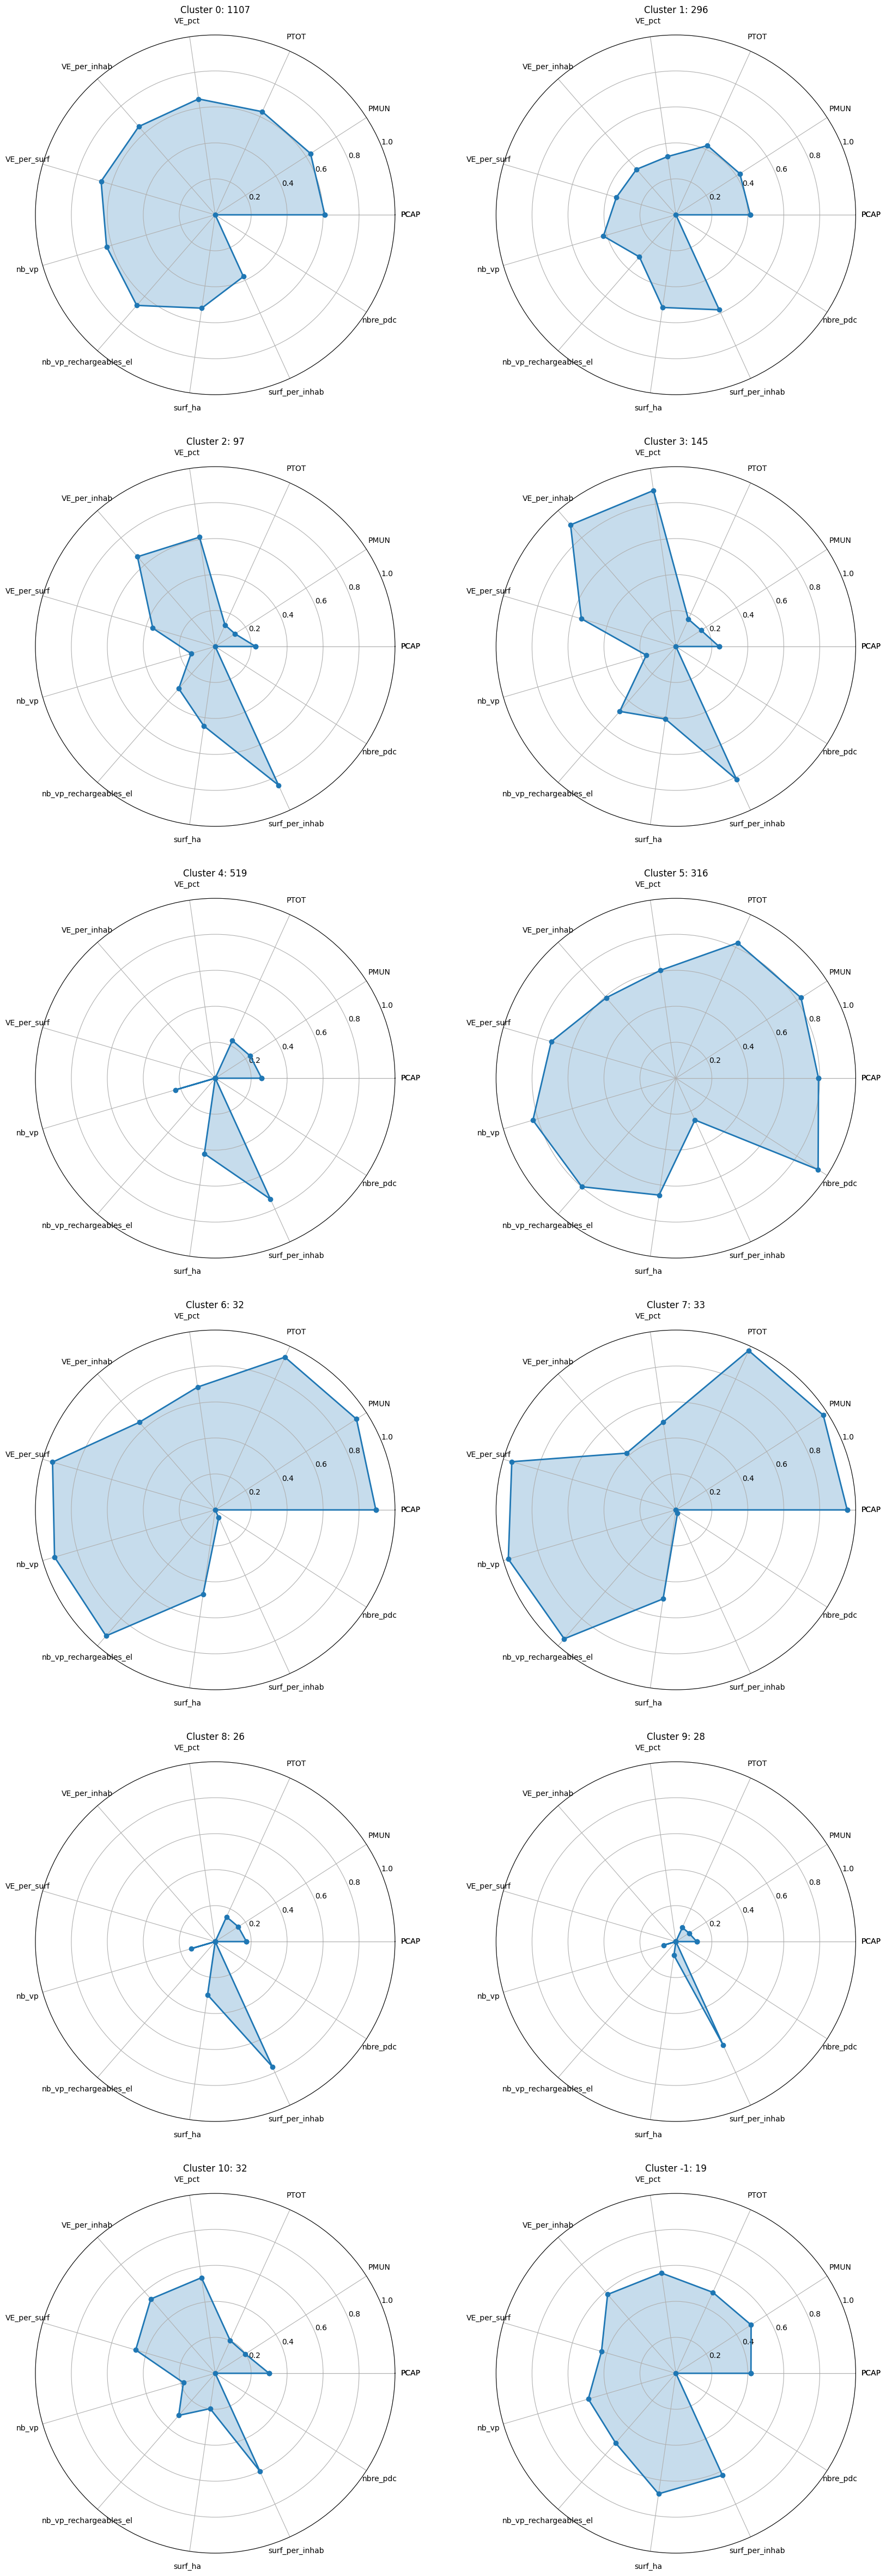

In [15]:
from sklearn.preprocessing import MinMaxScaler



# create a figure with multiple subplots
n_cols = 2
n_rows = round((len(unique_labels) + .5) / n_cols)
fig, axs = plt.subplots(nrows=n_rows,ncols=n_cols, figsize=(10*n_cols, 10*n_rows), subplot_kw=dict(projection='polar'))

axs = axs.flatten()

# scaler = MinMaxScaler()

# create a radar plot for each cluster
for i, label in enumerate(unique_labels):
    # get the rows of 'df' that belong to this cluster
    mask = (labels == label)
    sub_df = scaled_datas_personas[mask]
    
    # compute the mean of each variable in this cluster
    means = sub_df.mean()
    
    # create a list of variable names and values
    var_names = means.index.tolist()
    var_values = means.values
    
    # close the radar plot by repeating the first coordinate
    var_values = np.concatenate([var_values, [var_values[0]]])
    
    # create a polar axis for the current subplot
    ax = axs[i] if len(unique_labels) > 1 else axs
    
    # set the title of the subplot to the cluster label
    ax.set_title(f'Cluster {label}: {sub_df.shape[0]}')
    
    # create the radar plot for this cluster
    angles = np.linspace(0, 2*np.pi, len(var_names), endpoint=False)
    angles = np.concatenate([angles, [angles[0]]])
    ax.plot(angles, var_values, 'o-', linewidth=2)
    ax.fill(angles, var_values, alpha=0.25)
    
    # set the ticks along the radial axis
    ax.set_xticks(angles)
    var_names.append(var_names[0])
    ax.set_xticklabels(var_names)
    ax.tick_params(axis='x', pad=10)
    
    ax.set_ylim(0, 1)  # adjust the limits as needed
    ax.grid(True)

    # break

# show the plot
plt.show()


---------------------------------------------------------------------------

# Kmeans

In [16]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4, random_state=0).fit(embeddings)

------------------------------------------------------------

# Evolution

In [17]:
evolution_df = pd.DataFrame()
evolution_df['insee'] = communes.query( request).insee


In [18]:
regional_series = communes.query( 'region_name == @REGION')

In [19]:
import scipy as sp

def dbscan_predict(model, X):

    nr_samples = X.shape[0]

    y_new = np.ones(shape=nr_samples, dtype=int) * -1

    for i in range(nr_samples):
        diff = model.components_ - X[i, :]  # NumPy broadcasting

        dist = np.linalg.norm(diff, axis=1)  # Euclidean distance

        shortest_dist_idx = np.argmin(dist)

        if dist[shortest_dist_idx] < model.eps:
            y_new[i] = model.labels_[model.core_sample_indices_[shortest_dist_idx]]

    return y_new

In [20]:
for date in regional_series.date_arrete.unique():
    print(date)
    if date:
        datas = regional_series.query('date_arrete == @date')
        umap_datas = communes.join(pdc_at_date, how='left', on='insee', validate='m:1')\
                            .query( request)[
                                            [
                                                'nbre_pdc',
                                                
                                                # 'VE_pct',
                                                # 'VE_per_ha',
                                                'nb_vp',
                                                'VE_per_inhab',
                                                'VE_per_surf',
                                                'surf_per_inhab', 
                                            ]
                                                                                
                                            ]\
                            .fillna(0).apply(lambda x : x **  (1/3)) # to push left skewed distribution to normality
        
        # Scale the data
        scaled_umap_datas = umap_scaler.transform(umap_datas.values)

        # Create Embeddings
        embeddings = reducer.transform(scaled_umap_datas)

        # predict new cluster labels
        # evolution_df[f'{date}_d'] = dbscan_predict(dbscan, embeddings)
        evolution_df[f'{date}_k'] = kmeans.predict( embeddings)


    # break
evolution_df 

2021-03-31
2021-06-30
2022-12-31
2020-12-31
2021-09-30
2021-12-31
2022-03-31
2022-06-30
2022-09-30
None


,insee,2021-03-31_k,2021-06-30_k,2022-12-31_k,2020-12-31_k,2021-09-30_k,2021-12-31_k,2022-03-31_k,2022-06-30_k,2022-09-30_k
15582,76706,3,3,3,3,3,3,3,3,3
15583,76298,3,3,3,3,3,3,3,3,3
15584,76425,1,1,1,1,1,1,1,1,1
15585,76368,3,3,3,3,3,3,3,3,3
15586,76494,3,3,3,3,3,3,3,3,3
...,...,...,...,...,...,...,...,...,...,...
34369,27102,3,3,3,3,3,3,3,3,3
34370,27089,3,3,3,3,3,3,3,3,3
34371,76702,3,3,3,3,3,3,3,3,3
34429,61230,1,1,1,1,1,1,1,1,1


In [86]:
index = [ f'C_{i}' for i in range(0,4)]

clusters = pd.DataFrame(evolution_df.groupby( '2021-03-31_k')['insee'].count())
for col in evolution_df.columns.tolist()[1:]:
    pd.concat([
        clusters,pd.DataFrame(evolution_df.groupby( col)['insee'].count())
    ], axis=1)

clusters

,insee
2021-03-31_k,
0,574
1,474
2,492
3,1110


In [60]:
evolution_df['2021-03-31_k'].value_counts().sort_index()

0     574
1     474
2     492
3    1110
Name: 2021-03-31_k, dtype: int64

ValueError: The scaled sum of the connected flows is 9977, which is not within the tolerance (1e-06)

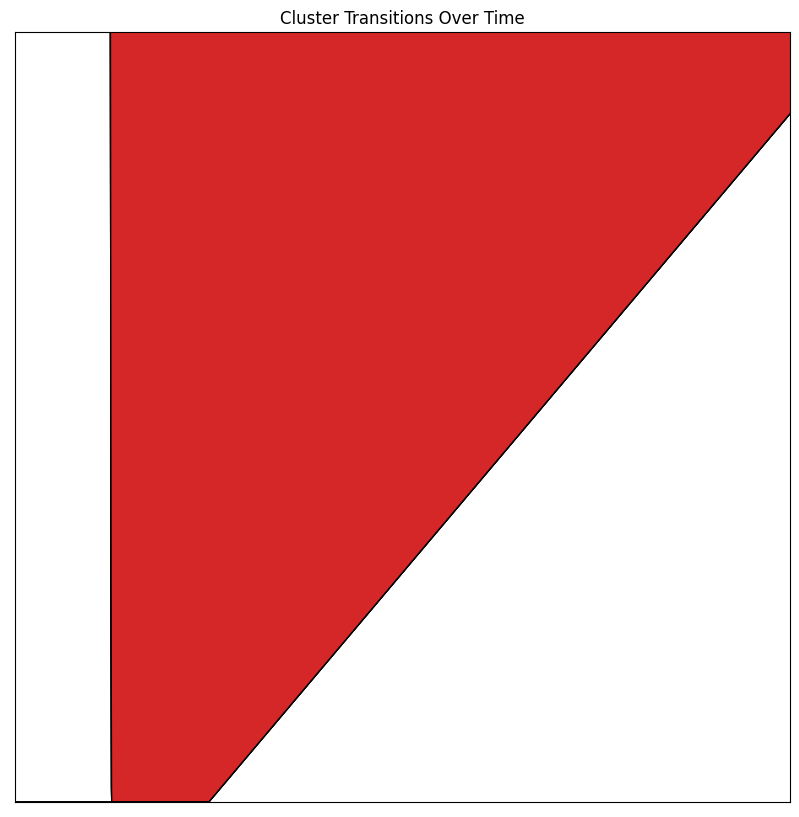

In [63]:
import matplotlib.pyplot as plt
from matplotlib.sankey import Sankey
from collections import defaultdict

# Create a list of all cluster states
states = set(evolution_df.iloc[:, 1:].values.flatten())

# Create a dictionary to map cluster states to unique integer values
state_to_idx = {s: i for i, s in enumerate(sorted(states))}

# Initialize a defaultdict to store the count of transitions between each pair of cluster states
transitions = defaultdict(int)

# Loop through each row of the DataFrame and update the count of transitions
for i in range(len(evolution_df) - 1):
    row1, row2 = evolution_df.iloc[i], evolution_df.iloc[i+1]
    for j in range(1, len(row1)):
        transitions[(state_to_idx[row1[j]], state_to_idx[row2[j]])] += 1

# Create the labels list for the nodes in the Sankey diagram
labels = [f"{evolution_df.iloc[i, 0]} ({state})" for state, i in state_to_idx.items()]

# Create the Sankey diagram
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[], title="Cluster Transitions Over Time")
sankey = Sankey(ax=ax, unit=None)

# Add the nodes to the diagram
for i, label in enumerate(labels):
    sankey.add(flows=[5000,5000,5000,5000], label=label,)

# Add the flows to the diagram
for (i, j), count in transitions.items():
    if i == j:
        movement = 0
    elif i > j:
        movement = 1
    else:
        movement = -1  
    sankey.add(flows=[count], orientations=[movement], lw=1, color='blue',prior=0,conect=(1,0))

# Finalize and display the diagram
sankey.finish()
plt.show()


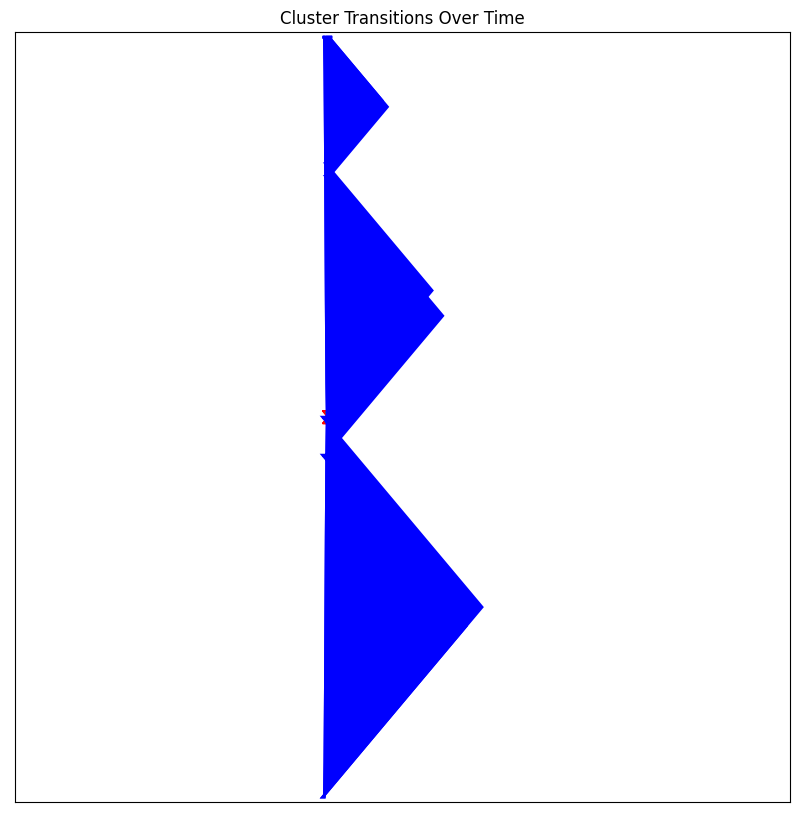

In [57]:
# Create the Sankey diagram
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(1, 1, 1, xticks=[], yticks=[], title="Cluster Transitions Over Time")
sankey = Sankey(ax=ax, unit=None)
flows =[[10,20,30],[11,22,27],[12,233,25]]
orientations = [[0,0,0],[0,0,0], [0,0,0]]

for l in ['cluster1','cluster2','cluster3']:
    sankey.add(flows=None, label=l, lw=1, color='red',)

for i in range(2):
    sankey.add(flows=flows[i], orientations=orientations[i], lw=2,  edgecolor='blue', facecolor='blue')
sankey.finish()
plt.show()


In [61]:
evolution_df['2021-03-31_k'].value_counts().sort_index()


0     574
1     474
2     492
3    1110
Name: 2021-03-31_k, dtype: int64

In [50]:
transitions

defaultdict(int,
            {(3, 3): 4977,
             (3, 1): 1530,
             (1, 3): 1431,
             (3, 2): 1800,
             (2, 3): 1809,
             (3, 0): 1683,
             (0, 3): 1764,
             (0, 0): 1611,
             (0, 2): 828,
             (2, 1): 846,
             (1, 0): 1080,
             (0, 1): 954,
             (2, 2): 981,
             (2, 0): 792,
             (1, 2): 819,
             (1, 1): 936})

In [51]:
for (i, j), count in transitions.items():
    if i == j:
        movement = 0
    elif i > j:
        movement = 1
    else:
        movement = -1    
    print(i,j,count,'movement', movement)

3 3 4977 movement 0
3 1 1530 movement 1
1 3 1431 movement -1
3 2 1800 movement 1
2 3 1809 movement -1
3 0 1683 movement 1
0 3 1764 movement -1
0 0 1611 movement 0
0 2 828 movement -1
2 1 846 movement 1
1 0 1080 movement 1
0 1 954 movement -1
2 2 981 movement 0
2 0 792 movement 1
1 2 819 movement -1
1 1 936 movement 0
